### EDA on Audio Datasets

Datasets are collected using [__Mimic Recording Studio__](https://github.com/MycroftAI/mimic-recording-studio) to record personal voice. The datasets are stored in the `backend/audioFile/{uuid}` directory along with the corresponding transcripts under metadata text file.

### Load Metadata of Recordings

In [1]:
# Open transcript.txt
file_path = 'luluw_recordings/transcript.txt'

audio_data = []
with open(file_path, 'r', encoding='utf-8') as f:
    for line in f:
        parts = line.split('|')
        if len(parts) == 3:
            filename, transcript, _ = parts
            audio_data.append((filename, transcript))

# Display filename and transcript
audio_data[0]

('d54aed3276ddc93de61f0875fab1964d.wav',
 'Many non-infectious diseases have a partly or completely genetic basis and may thus be transmitted from one generation to another.')

In [2]:
import os 
import numpy as np
import librosa
import torchaudio
from IPython.display import Audio
from matplotlib import pyplot as plt

In [3]:
relative_path = "luluw_recordings"

audio_file0 = os.path.join(relative_path, audio_data[0][0])
audio_file1 = os.path.join(relative_path, audio_data[10][0])
audio_file2 = os.path.join(relative_path, audio_data[200][0])
audio_file3 = os.path.join(relative_path, audio_data[300][0])

# Load the audio files
data0, sr0 = torchaudio.load(audio_file0)
data1, sr1 = torchaudio.load(audio_file1)
data2, sr2 = torchaudio.load(audio_file2)
data3, sr3 = torchaudio.load(audio_file3)

# Check the sample rate of the audio
print(f"Sample rates are {sr0}, {sr1}, {sr2}, {sr3}")

Sample rates are 44100, 44100, 44100, 44100


__44.1 Khz__ is too high sample rate and it consumes too much space. So, we can __downsample__ to __16Khz__ and then augment the dataset by making more copies but with added noise, pitch shifting, and time stretching. This way we can have 4x more samples than the original dataset.

### Generate Log Mel Spectrograms

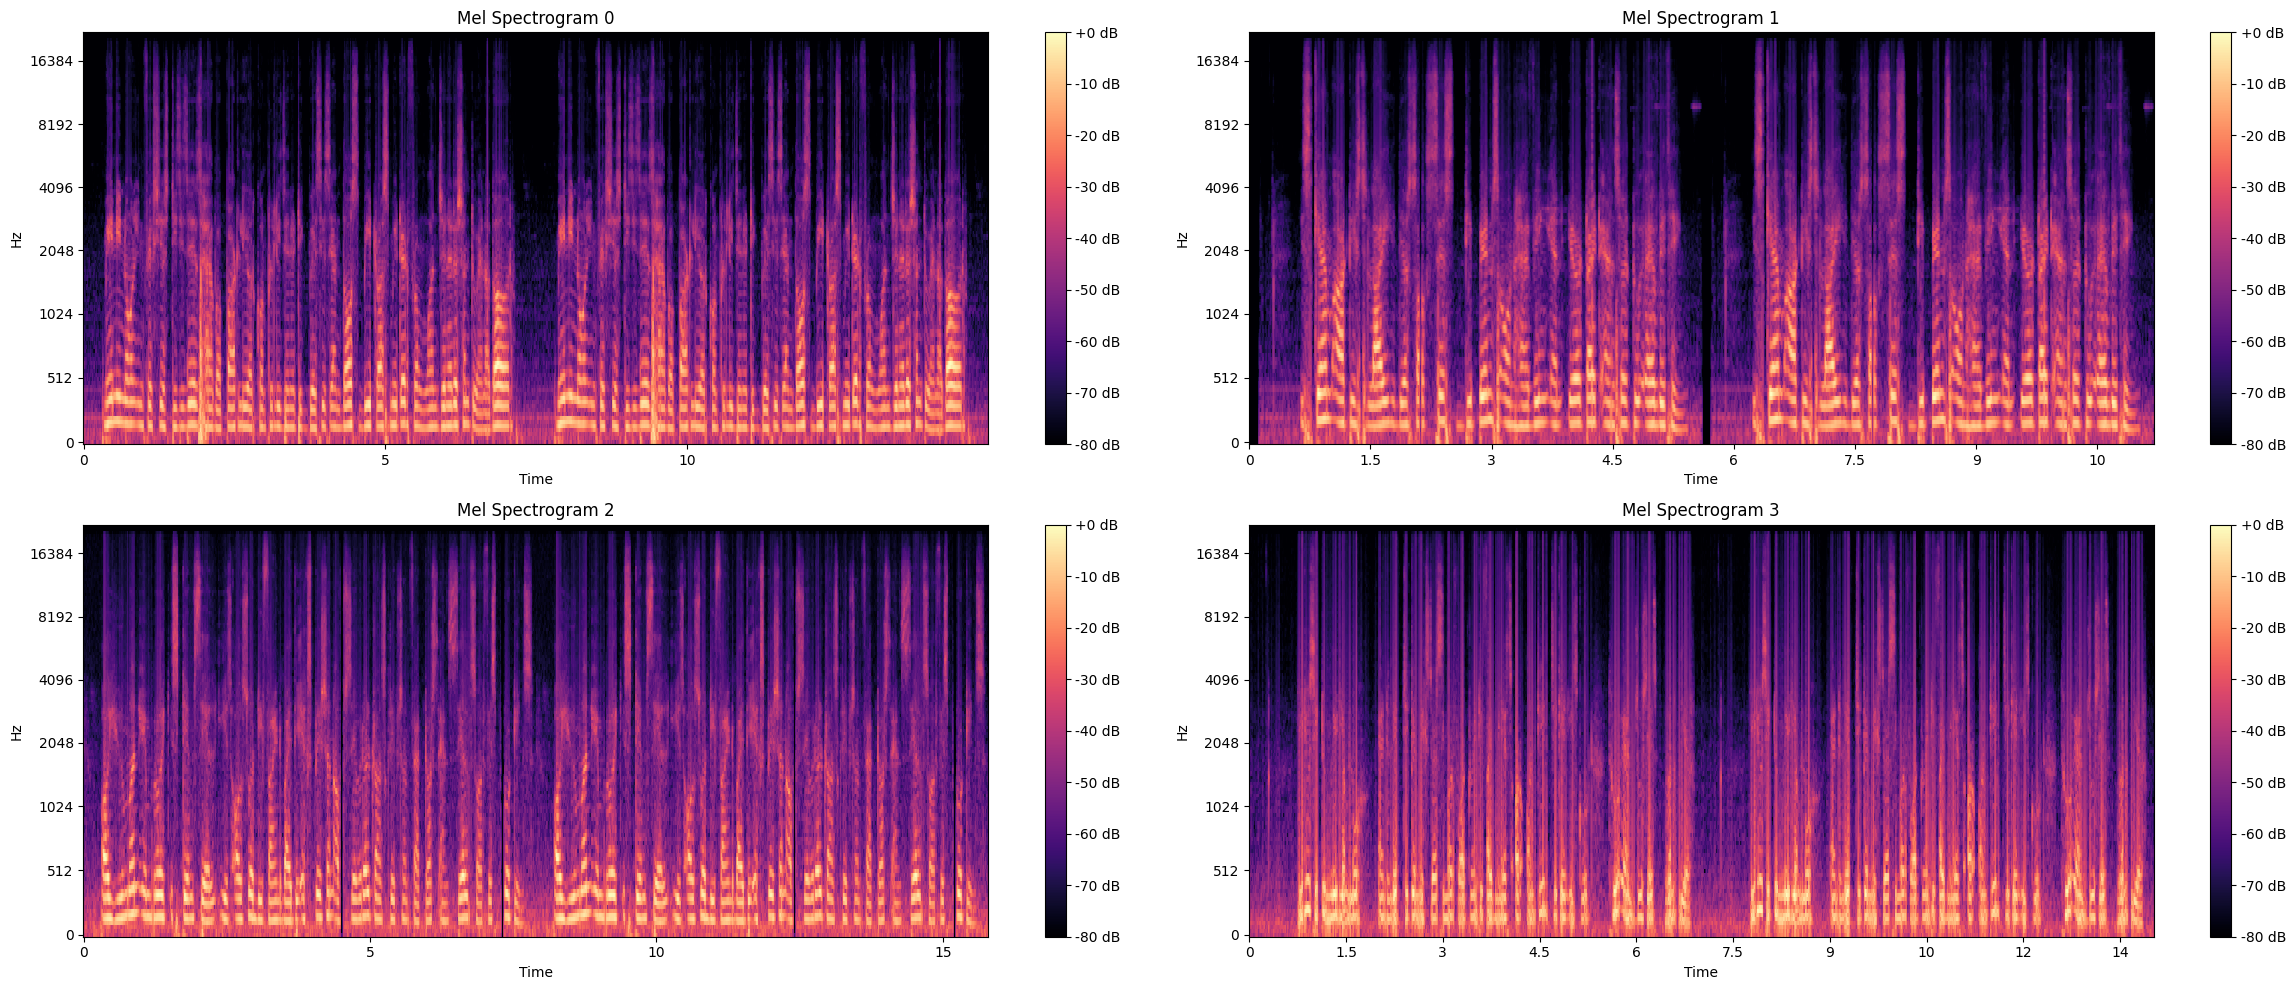

In [4]:
audio_data = [data0, data1, data2, data3]
sample_rate = sr0

# Generating log Mel Spectrogram
fig, ax = plt.subplots(2, 2, figsize=(24, 10))

for idx, data in enumerate(audio_data):
    data = data.numpy().flatten()

    # Compute Mel spectrogram
    spectrogram = librosa.feature.melspectrogram(y=data, sr=sample_rate, n_mels=128, fmax=sample_rate/2)
    log_spectrogram = librosa.power_to_db(spectrogram, ref=np.max)

    row = idx // 2
    col = idx % 2
    img = librosa.display.specshow(log_spectrogram, sr=sample_rate, x_axis='time', y_axis='mel', ax=ax[row, col])
    ax[row, col].set_title(f'Mel Spectrogram {idx}')
    fig.colorbar(img, ax=ax[row, col], format='%+2.0f dB')

plt.tight_layout()
plt.show()

### Add Noise, Stretch, Shift & Pitch shift

- Data augmentation creates new synthetic data by slightly altering our original training data.
- For audio, we can generate new data by adding noise, shifting in time, changing pitch, and adjusting speed.
- The goal is to help our model become more robust to these changes and improve its ability to generalize.
- To be effective, these changes must keep the original label of the training sample.
- For images, data augmentation can involve shifting, zooming, and rotating the image.

In [22]:
def noise(data, noise_rate=0.028):
    noise_amp = noise_rate*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

# Reference: https://librosa.org/doc/latest/generated/librosa.effects.time_stretch.html#librosa.effects.time_stretch
def stretch(data, rate=0.8):
    return librosa.effects.time_stretch(y=data, rate=rate)

def shift(data):
    shift_range = int(np.random.uniform(low=-5, high = 5)*1700)
    return np.roll(data, shift_range)

# Reference: https://librosa.org/doc/latest/generated/librosa.effects.pitch_shift.html#librosa.effects.pitch_shift
def pitch(data, sampling_rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(y=data, sr=sampling_rate, n_steps=pitch_factor)

#### 1. Orginal Sample Audio

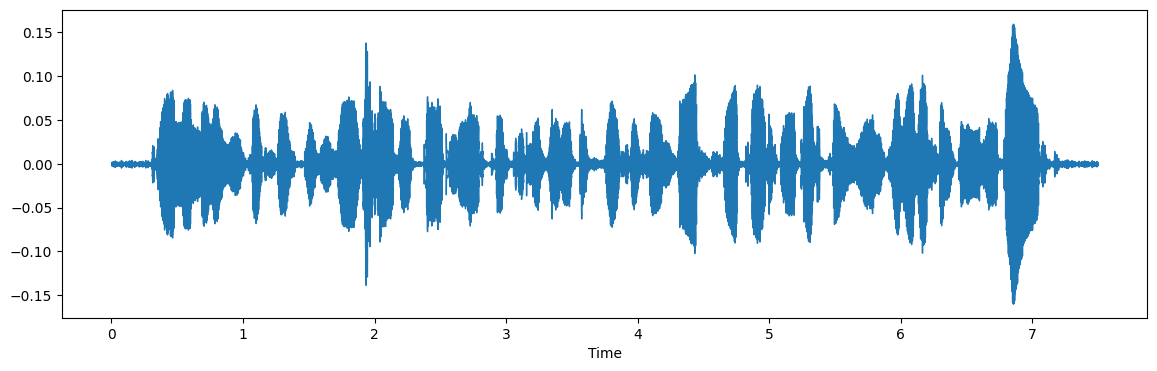

In [7]:
path = audio_file0
data, sample_rate = librosa.load(path)

plt.figure(figsize=(14,4))
librosa.display.waveshow(y=data, sr=sample_rate)
Audio(path)

#### 2. Audio Sample with Noise Injection

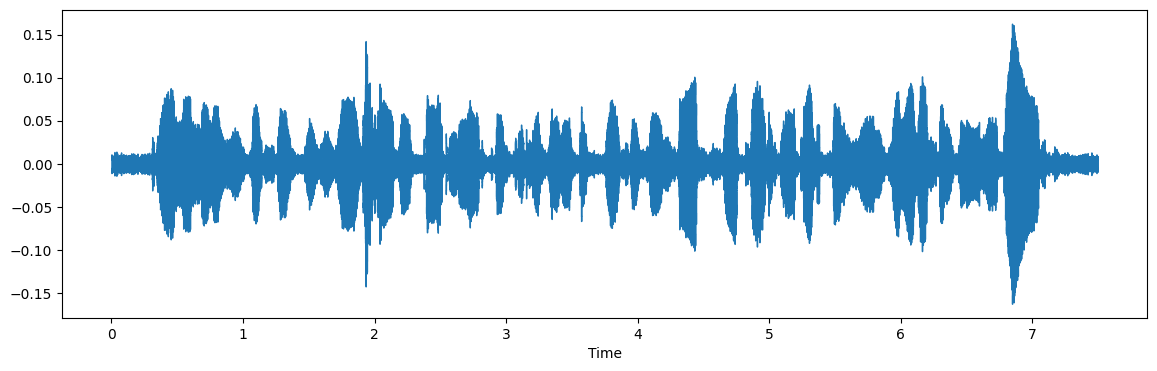

In [19]:
x = noise(data)
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

#### 3 Audio Sample with added Stretch

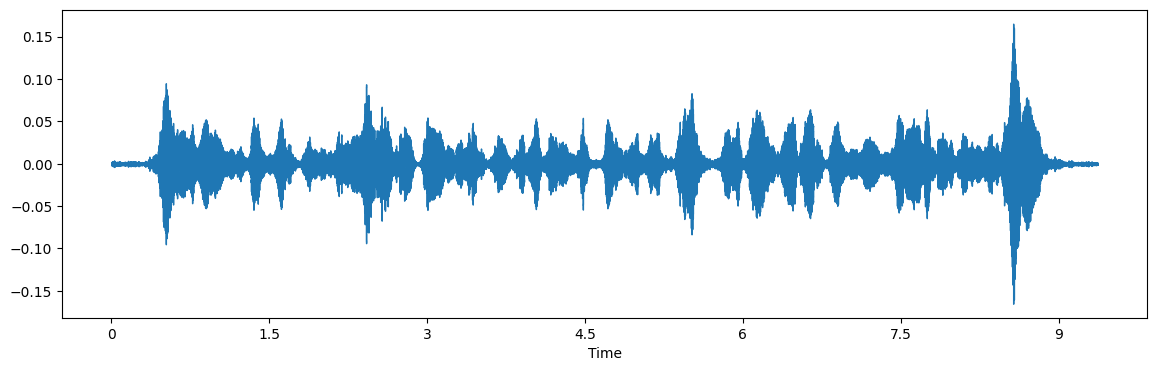

In [20]:
x = stretch(data)
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

#### 4. Audio Sample with added Shifting

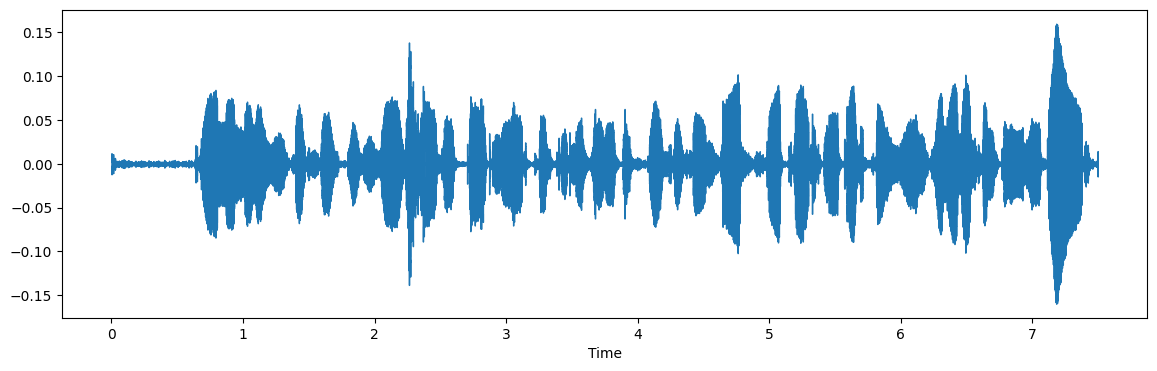

In [23]:
x = shift(data)
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

#### 5. Audio Sample with added Pitch Shift

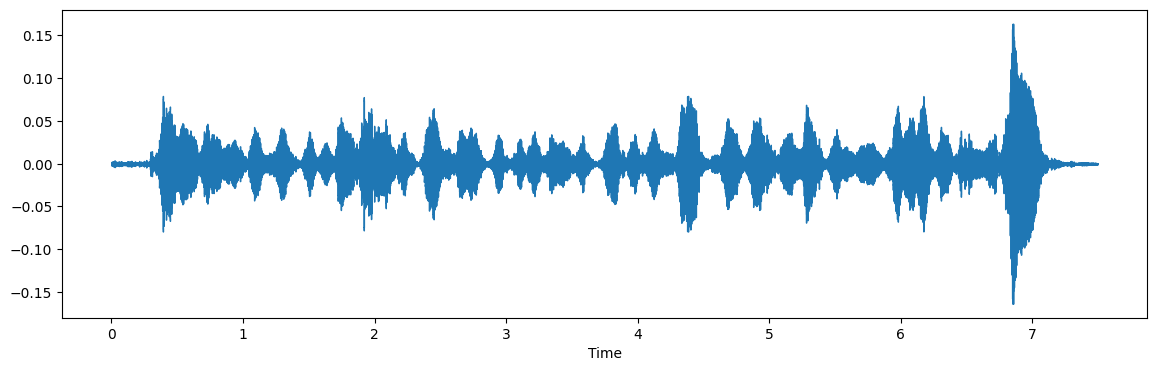

In [24]:
x = pitch(data, sample_rate)
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)